# Hypergraph information

In [22]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from tqdm import tqdm

sys.path.append("../src/")

import xgi
from reducibility_hg import *

sb.set_theme(style="ticks", context="paper")

In [23]:
results_dir = "../results/"
out_dir = f"{results_dir}datasets/"

## hypergraph datasets

In [24]:
data_names = [
    "email-enron",
    "email-eu",
    "hospital-lyon",
    "contact-high-school",
    "contact-primary-school",
    "tags-ask-ubuntu",
    "congress-bills",
    # "disgenenet",
    # "diseasome",
    # "ndc-substances",
    # "coauth-mag-geology",
    # "coauth-mag-history",
]

HGs = {}
for name in tqdm(data_names):
    HGs[name] = xgi.load_xgi_data(name, max_order=None, cache=True)

100%|█████████████████████████████████████████████| 7/7 [00:07<00:00,  1.06s/it]


In [66]:
pacs = 5
name = f"PACS{pacs}"
H0 = xgi.read_json(f"../data/{name}.json")
print(H0)
H0.cleanup(isolates=False)
print(H0)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Unnamed Hypergraph with 17993 nodes and 6859 hyperedges
Unnamed Hypergraph with 17800 nodes and 5770 hyperedges


In [48]:
i = 6  # choose dataset here
name = data_names[i]
print(name)
H0 = HGs[name]
print(H0)
print("max order:", xgi.max_edge_order(H0))
H0.cleanup(isolates=True)
print(H0)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

congress-bills
Hypergraph named congress-bills with 1718 nodes and 282049 hyperedges
max order: 399
Hypergraph named congress-bills with 1718 nodes and 104039 hyperedges


In [67]:
L_multi = xgi.multiorder_laplacian(
    H0, orders, weights, rescale_per_node=False, sparse=True
)

In [72]:
L_multi = L_multi.toarray()

In [68]:
L_multi.shape

(17800, 17800)

In [69]:
tau_c = find_charact_tau(H0, orders, weights, sparse=True)

In [70]:
tau_c

4.752448902624378e-06

In [73]:
eigenvals, eigenvectors = np.linalg.eigh(L_multi)

In [74]:
eigenvals, eigenvectors = np.linalg.eigh(L_multi)

# Compute the matrix exponential using the eigendecomposition
expvals = np.exp(tau_c * eigenvals)
expA = np.dot(eigenvectors, np.dot(np.diag(expvals), eigenvectors.T))

In [90]:
from scipy.linalg import expm, logm

In [65]:
np.allclose(expm(tau_c * L_multi), expA)

True

In [44]:
%timeit expm(tau_c * L_multi)

1.12 ms ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [63]:
from scipy.sparse import csr_array

In [76]:
expA.shape

(17800, 17800)

In [87]:
rho = expA / np.trace(expA)
rho = rho + np.eye(len(rho)) * 10**-10

In [88]:
rho

array([[ 5.53606831e-05, -1.36452071e-09, -1.36452071e-09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.36452071e-09,  5.53606831e-05, -1.36452071e-09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.36452071e-09, -1.36452071e-09,  5.53627518e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.53591570e-05,  3.07341221e-27,  3.25019717e-27],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.07341221e-27,  5.54440760e-05, -1.27460871e-21],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.25019717e-27, -1.27531207e-21,  5.53591570e-05]])

In [ ]:
np.trace(rho @ logm(rho) - rho @ logm(rho))

In [80]:
expA_sp = csr_array(expA)
expA_sp

<17800x17800 sparse array of type '<class 'numpy.float64'>'
	with 316588002 stored elements in Compressed Sparse Row format>

In [79]:
316588002 / 17800**2

0.99920465219038

In [82]:
expA_sp.eliminate_zeros()

In [86]:
expA_sp.todense()[:5, :5]

array([[ 1.00007395e+00, -2.46496972e-05, -2.46496972e-05,
        -2.46496972e-05,  0.00000000e+00],
       [-2.46496972e-05,  1.00007395e+00, -2.46496972e-05,
        -2.46496972e-05,  0.00000000e+00],
       [-2.46496972e-05, -2.46496972e-05,  1.00011132e+00,
        -6.20194377e-05,  0.00000000e+00],
       [-2.46496972e-05, -2.46496972e-05, -6.20194377e-05,
         1.00011132e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00004638e+00]])

In [9]:
Ds_H, lZs_H, orders = compute_information(H0, tau_c, sparse=True)

/Users/maxime/.pyenv/versions/venv_xgi/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/maxime/.pyenv/versions/venv_xgi/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [10]:
Ds_H, lZs_H

(array([0.01654861, 0.01569046, 0.01404307, 0.01170881, 0.0089686 ,
        0.00664769, 0.00382031, 0.00185159, 0.        ]),
 array([0.01342429, 0.01344965, 0.01358906, 0.01402962, 0.0150333 ,
        0.01664093, 0.01960684, 0.02385424, 0.03034162]))

In [14]:
optimization(H0, tau_c, sparse=True)

(array([0.01654861, 0.01569046, 0.01404307, 0.01170881, 0.0089686 ,
        0.00664769, 0.00382031, 0.00185159, 0.        ]),
 array([0.01342429, 0.01344965, 0.01358906, 0.01402962, 0.0150333 ,
        0.01664093, 0.01960684, 0.02385424, 0.03034162]))

In [11]:
from scipy.sparse import csr_array, lil_array

In [16]:
# convert the CSR matrix to a LIL matrix
A_lil = lil_array(L_multi)

# define a function to compute the matrix logarithm on a submatrix
def logm_submatrix(A_sub_lil):
    A_sub = A_sub_lil.tocsr()  # convert the LIL matrix back to CSR format
    return logm(A_sub)


# split the matrix into submatrices
submatrices = [A_lil[i::num_procs] for i in range(num_procs)]

# create a pool of processes
pool = mp.Pool(processes=num_procs)

# compute the matrix logarithm in parallel
logA_sub = pool.map(logm_submatrix, submatrices)

# combine the results from the submatrices
logA = np.block(logA_sub)

Process SpawnPoolWorker-13:
Traceback (most recent call last):
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'logm_submatrix' on <module '__main__' (built-in)>
Process SpawnPoolWorker-14:
Traceback (most recent call last):
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._tar

  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


KeyboardInterrupt: 

Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'logm_submatrix' on <module '__main__' (built-in)>
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/maxime/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._targe

KeyboardInterrupt: 

In [10]:
L_multi

<75x75 sparse array of type '<class 'numpy.float64'>'
	with 2641 stored elements in Compressed Sparse Row format>

In [6]:
from scipy.linalg import expm, logm
import scipy.sparse as sp

In [ ]:
tau = 0.1
rho = sp.linalg.expm(-tau * L_multi)

/Users/maxime/.pyenv/versions/venv_xgi/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/maxime/.pyenv/versions/venv_xgi/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [ ]:
rho = rho / rho.trace()
rho = rho + sp.eye(rho.shape[0]) * 10**-10

In [14]:
logm(rho.toarray())

array([[-1.53210194e+01,  1.50767289e-01,  2.79357302e-01, ...,
         6.13330308e-03,  1.37906863e-01,  5.59151121e-02],
       [ 1.50767289e-01, -5.75133805e+00,  2.47396902e-01, ...,
         1.15351007e-06, -1.24154794e-04, -4.31915328e-05],
       [ 2.79357302e-01,  2.47396902e-01, -7.23645387e+00, ...,
         2.47590616e-06,  2.22930294e-04, -3.57510294e-05],
       ...,
       [ 6.13330308e-03,  1.15351008e-06,  2.47590616e-06, ...,
        -3.49466017e+00,  8.24218259e-06, -1.22913676e-06],
       [ 1.37906863e-01, -1.24154796e-04,  2.22930293e-04, ...,
         8.24218254e-06, -8.95849265e+00,  1.36699281e-01],
       [ 5.59151121e-02, -4.31915334e-05, -3.57510297e-05, ...,
        -1.22913677e-06,  1.36699281e-01, -4.69609564e+00]])

In [27]:
np.trace(L_multi.toarray())

28860.0

In [52]:
L_multi

<148x148 sparse array of type '<class 'numpy.float64'>'
	with 5309 stored elements in Compressed Sparse Row format>

In [61]:
from scipy.sparse.linalg import expm

In [62]:
expm(-0.1 * L_multi)

<148x148 sparse array of type '<class 'numpy.float64'>'
	with 20454 stored elements in Compressed Sparse Row format>

In [10]:
sp.linalg.logm(L_multi)

NameError: name 'sp' is not defined

In [73]:
148**2

21904

In [28]:
from scipy.linalg import eigvals, eigvalsh
from scipy.sparse.linalg import eigsh

In [ ]:
eigvalsh(L_multi.toarray())

In [37]:
eigvalsh(L_multi.toarray())

array([-1.33337785e-13,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.76008597e-01,  5.52115511e-01,
        1.43426264e+00,  1.46532757e+00,  2.34491796e+00,  2.39823876e+00,
        4.18387924e+00,  4.86142542e+00,  5.15834799e+00,  5.49223890e+00,
        1.00817510e+01,  1.05510175e+01,  1.29302543e+01,  1.34776693e+01,
        1.62711629e+01,  1.66328003e+01,  1.69337703e+01,  1.76241019e+01,
        1.87706116e+01,  1.89309315e+01,  2.09662401e+01,  2.24596529e+01,
        2.29243312e+01,  2.50224564e+01,  2.56240456e+01,  2.92050077e+01,
        3.06490916e+01,  3.16666193e+01,  3.19653070e+01,  3.47948780e+01,
        3.51697134e+01,  3.52735013e+01,  3.55417371e+01,  3.63909810e+01,
        4.00905569e+01,  4.08253436e+01,  4.37098337e+01,  4.57512855e+01,
        5.07242580e+01,  5.09889577e+01,  5.35744241e+01,  5.52279542e+01,
        5.74426630e+01,  6.16481782e+01,  7.27728925e+01,  7.51102278e+01,
        7.83157988e+01,  

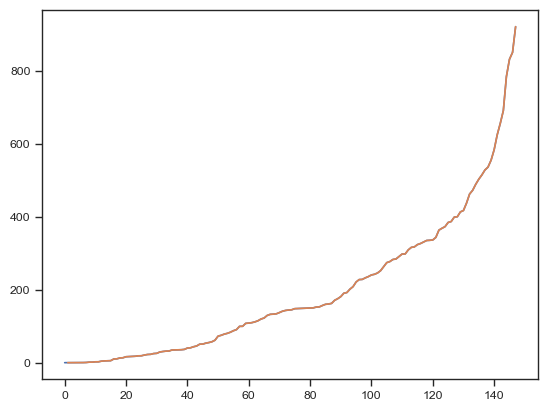

In [47]:
plt.plot(range(148), eigvalsh(L_multi.toarray()))

vals, eigs = eigsh(L_multi, k=147)
vals

plt.plot(range(148 - 147, 148), vals)

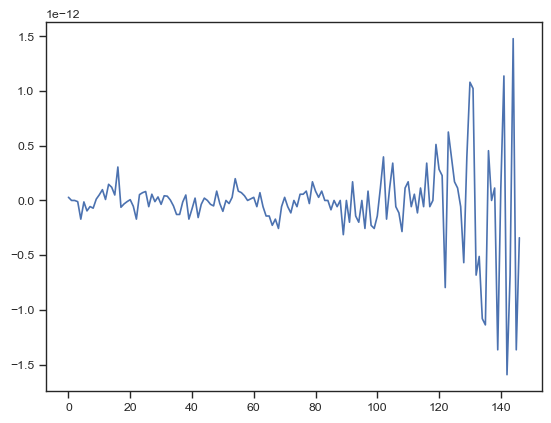

In [48]:
plt.plot(eigvalsh(L_multi.toarray())[1:] - vals[:])

In [51]:
vals, eigs = eigsh(L_multi, k=1)
vals

array([922.29401487])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        41,  42,  46,  48,  52,  57,  58,  61,  62,  67,  68,  69,  70,
        71,  73,  74,  84, 176, 408, 411])

In [17]:
eigs[:, 0]

array([ 6.32279796e-18,  8.39469061e-20, -2.69153033e-18, ...,
       -7.58111250e-18, -2.24167559e-06, -4.57971360e-18])

### Compute info

In [4]:
i = 2  # choose dataset here
name = data_names[i]
print(name)
H0 = HGs[name]
print(H0)
print("max order:", xgi.max_edge_order(H0))
H0.cleanup(isolates=True)
print(H0)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

hospital-lyon
Hypergraph named hospital-Lyon with 75 nodes and 21398 hyperedges
max order: 9
Hypergraph named hospital-Lyon with 75 nodes and 2945 hyperedges


In [5]:
from scipy.sparse.linalg import expm, logm

ImportError: cannot import name 'logm' from 'scipy.sparse.linalg' (/Users/maxime/.pyenv/versions/venv_xgi/lib/python3.9/site-packages/scipy/sparse/linalg/__init__.py)

In [6]:
import multiprocessing as mp

In [42]:
from scipy import linalg


def KL(rho_emp, rho_model):
    """
    Computes the Kullback-Leibler (KL) divergence between an empirical observation `rho_emp` and a model `rho_model`.

    Parameters
    ----------
    rho_emp : (np.ndarray)
        The empirical observation
    rho_model : np.ndarray
        The model

    Returns
    -------
    float: the KL divergence between `rho_emp` and `rho_model`
    """
    return np.trace(
        np.matmul(rho_emp, linalg.logm(rho_emp))
        - np.matmul(rho_emp, linalg.logm(rho_model))
    )


def optimization(H, tau, rescale_per_node=False):
    """
    Computes the gain and loss for modeling a hypergraph (up to order `d_max`),
    using a part of it, up to order `d < d_max`.

    Parameters
    ----------
    H: xgi Hypergraph
        The input hypergraph
    tau: float
        The scale of signal propagation

    Returns
    -------
    D: numpy.ndarray
        The learning error
    lZ: numpy.ndarray
        The penalization term for model complexity
    """
    orders = np.array(xgi.unique_edge_sizes(H)) - 1
    weights = np.ones(len(orders))
    L_multi = xgi.multiorder_laplacian(
        H, orders, weights, rescale_per_node=rescale_per_node
    )

    rho_all = density(L_multi, tau)

    D = []  # Learning error
    lZ = []  # Penalization term for model complexity
    N = H.num_nodes

    for l in range(len(orders)):
        L_l = xgi.multiorder_laplacian(
            H, orders[0 : l + 1], weights[0 : l + 1], rescale_per_node=rescale_per_node
        )
        rho_l = density(L_l, tau)
        d = KL(rho_all, rho_l)
        z = penalization(L_l, tau)

        D.append(d)
        lZ.append(z)

    lZ = np.array(lZ)
    D = np.array(D)

    return D, lZ

In [44]:
%timeit optimization(H0, 0.1)

6.39 s ± 402 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
from numba import jit, njit

In [69]:
@jit
def KL_nb(rho_emp, rho_model):
    return np.trace(
        np.dot(rho_emp, linalg.logm(rho_emp)) - np.dot(rho_emp, linalg.logm(rho_model))
    )


def optimization_nb(H, tau, rescale_per_node=False):
    orders = np.array(xgi.unique_edge_sizes(H)) - 1
    weights = np.ones(len(orders))
    L_multi = xgi.multiorder_laplacian(
        H, orders, weights, rescale_per_node=rescale_per_node
    )

    rho_all = density(L_multi, tau)

    D = []  # Learning error
    lZ = []  # Penalization term for model complexity
    N = H.num_nodes

    for l in range(len(orders)):
        L_l = xgi.multiorder_laplacian(
            H, orders[0 : l + 1], weights[0 : l + 1], rescale_per_node=rescale_per_node
        )
        rho_l = density(L_l, tau)
        d = KL_nb(rho_all, rho_l)
        z = penalization(L_l, tau)

        D.append(d)
        lZ.append(z)

    lZ = np.array(lZ)
    D = np.array(D)

    return D, lZ

In [72]:
%timeit optimization_nb(H0, 0.1)

5.39 s ± 1.44 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
orders

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [31]:
tau_c = find_charact_tau(H0, orders, weights)

In [32]:
Ds_H, lZs_H, orders = compute_information(H0, tau_c)
Q = Ds_H + lZs_H

logm result may be inaccurate, approximate err = 4.1847167069269826e-12



KeyboardInterrupt



### Plot

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 2.1), constrained_layout=True)


ax1.plot(orders, Ds_H, "o-", ms=7, mfc="w", lw=2)

ax1.set_title("Information Loss (KL)")
ax1.set_xlabel("Max Order")
ax1.set_ylabel("Bits")

ax2.plot(orders, lZs_H, "o-", ms=7, mfc="w", lw=2)
ax2.set_title("Model Complexity ($\delta S$)")
ax2.set_xlabel("Max Order")

ax3.plot(orders, Q, "o-", ms=7, mfc="w", lw=2)
y = np.where(Q == min(Q)) * np.ones(len(Q)) + 1
x = np.linspace(np.min(Q), np.max(Q), len(Q))
ax3.plot(y[0], x, c="r", lw=4, alpha=0.7, ls="--", zorder=-2)

ax3.set_title("Message Length")
ax3.set_xlabel("Max Order")

fig.suptitle(f"{name}")

fig_name = f"message_length_{name}"  # lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [ ]:
np.savez(f"{out_dir}{fig_name}.npz", Q=Q, Ds_H=Ds_H, lZs_H=lZs_H, orders=orders)

### Multiple taus

In [4]:
taus = [0.01, 0.1, 1]

Ds_H0, lZs_H0, orders = compute_information(H0, taus)

Ds_H = []
lZs_H = []

for i, H in enumerate(Hs):
    Ds_Hi, lZs_Hi, _ = compute_information(H, taus)
    Ds_H.append(Ds_Hi)
    lZs_H.append(lZs_Hi)

  0%|                                                           | 0/3 [00:00<?, ?it/s]

logm result may be inaccurate, approximate err = 8.016742853678119e-13
logm result may be inaccurate, approximate err = 8.016742853678119e-13
logm result may be inaccurate, approximate err = 4.350871144409221e-13
logm result may be inaccurate, approximate err = 8.016742853678119e-13
logm result may be inaccurate, approximate err = 5.737900525699966e-13
logm result may be inaccurate, approximate err = 8.016742853678119e-13
logm result may be inaccurate, approximate err = 6.203558125681481e-13
logm result may be inaccurate, approximate err = 8.016742853678119e-13
logm result may be inaccurate, approximate err = 6.773212233745527e-13
logm result may be inaccurate, approximate err = 8.016742853678119e-13
logm result may be inaccurate, approximate err = 6.777192526438904e-13
logm result may be inaccurate, approximate err = 8.016742853678119e-13
logm result may be inaccurate, approximate err = 6.646021326160591e-13
logm result may be inaccurate, approximate err = 8.016742853678119e-13
logm r

 33%|█████████████████                                  | 1/3 [00:32<01:04, 32.14s/it]

logm result may be inaccurate, approximate err = 8.016742853678119e-13
logm result may be inaccurate, approximate err = 5.545146344167048e-13
logm result may be inaccurate, approximate err = 5.545146344167048e-13
logm result may be inaccurate, approximate err = 3.3062057911895115e-13
logm result may be inaccurate, approximate err = 5.545146344167048e-13
logm result may be inaccurate, approximate err = 4.1746236265241017e-13
logm result may be inaccurate, approximate err = 5.545146344167048e-13
logm result may be inaccurate, approximate err = 4.810776025461899e-13
logm result may be inaccurate, approximate err = 5.545146344167048e-13
logm result may be inaccurate, approximate err = 4.616164791306845e-13
logm result may be inaccurate, approximate err = 5.545146344167048e-13
logm result may be inaccurate, approximate err = 5.193045376130101e-13
logm result may be inaccurate, approximate err = 5.545146344167048e-13
logm result may be inaccurate, approximate err = 5.485694258565133e-13
logm

 67%|██████████████████████████████████                 | 2/3 [01:13<00:37, 37.57s/it]

logm result may be inaccurate, approximate err = 5.545146344167048e-13


  0%|                                                           | 0/3 [00:00<?, ?it/s]

logm result may be inaccurate, approximate err = 6.755343319530016e-13
logm result may be inaccurate, approximate err = 6.755343319530016e-13
logm result may be inaccurate, approximate err = 4.350871144409221e-13
logm result may be inaccurate, approximate err = 6.755343319530016e-13
logm result may be inaccurate, approximate err = 5.564852645269207e-13
logm result may be inaccurate, approximate err = 6.755343319530016e-13
logm result may be inaccurate, approximate err = 6.081482829268497e-13
logm result may be inaccurate, approximate err = 6.755343319530016e-13
logm result may be inaccurate, approximate err = 7.494668897480793e-13
logm result may be inaccurate, approximate err = 6.755343319530016e-13
logm result may be inaccurate, approximate err = 6.80331195162655e-13
logm result may be inaccurate, approximate err = 6.755343319530016e-13
logm result may be inaccurate, approximate err = 6.12934194294414e-13
logm result may be inaccurate, approximate err = 6.733813046114849e-13
logm res

 33%|█████████████████                                  | 1/3 [00:32<01:04, 32.02s/it]

logm result may be inaccurate, approximate err = 6.755343319530016e-13
logm result may be inaccurate, approximate err = 5.2440390326132e-13
logm result may be inaccurate, approximate err = 5.2440390326132e-13
logm result may be inaccurate, approximate err = 3.3062057911895115e-13
logm result may be inaccurate, approximate err = 5.2440390326132e-13
logm result may be inaccurate, approximate err = 4.39765895469052e-13
logm result may be inaccurate, approximate err = 5.2440390326132e-13
logm result may be inaccurate, approximate err = 5.498993759400098e-13
logm result may be inaccurate, approximate err = 5.2440390326132e-13
logm result may be inaccurate, approximate err = 5.173522064043902e-13
logm result may be inaccurate, approximate err = 5.2440390326132e-13
logm result may be inaccurate, approximate err = 5.139959220314275e-13
logm result may be inaccurate, approximate err = 5.2440390326132e-13
logm result may be inaccurate, approximate err = 5.056209685820947e-13
logm result may be i

 67%|██████████████████████████████████                 | 2/3 [01:12<00:37, 37.17s/it]

logm result may be inaccurate, approximate err = 5.2440390326132e-13


  0%|                                                           | 0/3 [00:00<?, ?it/s]

logm result may be inaccurate, approximate err = 5.959372360557085e-13
logm result may be inaccurate, approximate err = 5.959372360557085e-13
logm result may be inaccurate, approximate err = 4.350871144409221e-13
logm result may be inaccurate, approximate err = 5.959372360557085e-13
logm result may be inaccurate, approximate err = 5.737900525699966e-13
logm result may be inaccurate, approximate err = 5.959372360557085e-13
logm result may be inaccurate, approximate err = 6.203558125681481e-13
logm result may be inaccurate, approximate err = 6.06707253999062e-13
logm result may be inaccurate, approximate err = 7.285039839544788e-13
logm result may be inaccurate, approximate err = 6.06707253999062e-13
logm result may be inaccurate, approximate err = 6.654771462082654e-13
logm result may be inaccurate, approximate err = 5.959372360557085e-13
logm result may be inaccurate, approximate err = 5.93464251332303e-13
logm result may be inaccurate, approximate err = 5.959372360557085e-13
logm resu

 33%|█████████████████                                  | 1/3 [00:31<01:03, 31.80s/it]

logm result may be inaccurate, approximate err = 5.959372360557085e-13
logm result may be inaccurate, approximate err = 4.526050651602394e-13
logm result may be inaccurate, approximate err = 4.523732150897055e-13
logm result may be inaccurate, approximate err = 3.3062057911895115e-13
logm result may be inaccurate, approximate err = 4.523732150897055e-13
logm result may be inaccurate, approximate err = 4.1746236265241017e-13
logm result may be inaccurate, approximate err = 4.523732150897055e-13
logm result may be inaccurate, approximate err = 4.810776025461899e-13
logm result may be inaccurate, approximate err = 4.523732150897055e-13
logm result may be inaccurate, approximate err = 5.598011680242306e-13
logm result may be inaccurate, approximate err = 4.523732150897055e-13
logm result may be inaccurate, approximate err = 5.290408948119364e-13
logm result may be inaccurate, approximate err = 4.523732150897055e-13
logm result may be inaccurate, approximate err = 5.467058460914497e-13
logm

 67%|██████████████████████████████████                 | 2/3 [01:12<00:36, 36.97s/it]

logm result may be inaccurate, approximate err = 4.523732150897055e-13


  0%|                                                           | 0/3 [00:00<?, ?it/s]

logm result may be inaccurate, approximate err = 8.111860267793886e-13
logm result may be inaccurate, approximate err = 8.111860267793886e-13
logm result may be inaccurate, approximate err = 4.350871144409221e-13
logm result may be inaccurate, approximate err = 8.111860267793886e-13
logm result may be inaccurate, approximate err = 5.737900525699966e-13
logm result may be inaccurate, approximate err = 8.111860267793886e-13
logm result may be inaccurate, approximate err = 6.203558125681481e-13
logm result may be inaccurate, approximate err = 8.111860267793886e-13
logm result may be inaccurate, approximate err = 6.773212233745527e-13
logm result may be inaccurate, approximate err = 8.111860267793886e-13
logm result may be inaccurate, approximate err = 6.777192526438904e-13
logm result may be inaccurate, approximate err = 8.111860267793886e-13
logm result may be inaccurate, approximate err = 6.465965546932534e-13
logm result may be inaccurate, approximate err = 8.111860267793886e-13
logm r

 33%|█████████████████                                  | 1/3 [00:34<01:09, 34.55s/it]

logm result may be inaccurate, approximate err = 8.072132206851038e-13
logm result may be inaccurate, approximate err = 6.497154082081749e-13
logm result may be inaccurate, approximate err = 6.497154082081749e-13
logm result may be inaccurate, approximate err = 3.3062057911895115e-13
logm result may be inaccurate, approximate err = 6.497154082081749e-13
logm result may be inaccurate, approximate err = 4.1746236265241017e-13
logm result may be inaccurate, approximate err = 6.497154082081749e-13
logm result may be inaccurate, approximate err = 4.810776025461899e-13
logm result may be inaccurate, approximate err = 6.497154082081749e-13
logm result may be inaccurate, approximate err = 4.951315226212706e-13
logm result may be inaccurate, approximate err = 6.497154082081749e-13
logm result may be inaccurate, approximate err = 5.193045376130101e-13
logm result may be inaccurate, approximate err = 6.497154082081749e-13
logm result may be inaccurate, approximate err = 4.818043931424125e-13
logm

 67%|██████████████████████████████████                 | 2/3 [01:15<00:38, 38.46s/it]

logm result may be inaccurate, approximate err = 6.497154082081749e-13


100%|███████████████████████████████████████████████████| 3/3 [01:58<00:00, 39.58s/it]


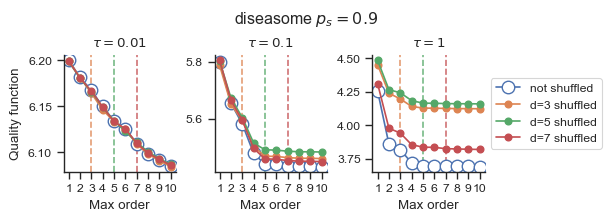

In [5]:
fig, axs = plt.subplots(
    1, len(taus), figsize=(2 * len(taus), 2.1), constrained_layout=True
)

for i, tau in enumerate(taus):

    axs[i].plot(orders, lZs_H0[i] - Ds_H0[i], "o-", label="not shuffled", ms=9, mfc="w")

    for j, H in enumerate(Hs):
        axs[i].plot(
            orders, lZs_H[j][i] - Ds_H[j][i], "o-", label=f"d={d_shuffles[j]} shuffled"
        )

        axs[i].axvline(d_shuffles[j], ls="--", c=f"C{j+1}", zorder=-2, alpha=0.8)

    axs[i].set_title(rf"$\tau = {tau}$", weight="bold")
    axs[i].set_xlabel("Max order")
    axs[i].set_xticks(orders)

axs[0].set_ylabel("Quality function")
axs[-1].legend(loc="center left", bbox_to_anchor=(1, 0.5))

sb.despine()

fig.suptitle(f"{name} $p_s={p_shuffle}$")

fig_name = (
    f"info_{name}_p_s_{p_shuffle}"  # lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"
)

# plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [6]:
H = xgi.Hypergraph([[1, 2], [1, 2, 3, 4]])

xgi.multiorder_laplacian(H, orders=[1, 2, 3], weights=[1, 1, 1])

/Users/maxime/Dropbox (ISI Foundation)/WORK/SCIENCE/xgi/xgi/linalg/matrix.py:310: UserWarning: No edges of order 2. Contribution of that order is zero. Its weight is effectively zero.
  warn(


array([[ 5., -3., -1., -1.],
       [-3.,  5., -1., -1.],
       [-1., -1.,  3., -1.],
       [-1., -1., -1.,  3.]])

In [7]:
xgi.multiorder_laplacian(H, orders=[1, 3], weights=[1, 1])

array([[ 5., -3., -1., -1.],
       [-3.,  5., -1., -1.],
       [-1., -1.,  3., -1.],
       [-1., -1., -1.,  3.]])

### Compute entropy

In [8]:
ents = {}

for i, tau in enumerate(taus):

    ents[tau] = {}

    for j, HG in enumerate([H0] + Hs):
        d_max = xgi.max_edge_order(HG)
        L_multi = np.zeros((HG.num_nodes, HG.num_nodes))
        for d in range(1, d_max + 1):
            # K, Adj, L = su.compute_laplacians(G, d+1)
            L = xgi.laplacian(HG, d, rescale_per_node=False)
            L_multi += L

        ent = entropy(L_multi, tau)

        dd = 0 if j == 0 else d_shuffles[j - 1]
        ents[tau][dd] = ent

ents_df = pd.DataFrame.from_dict(ents)

ents_df_long = (
    ents_df.stack().rename("entropy").to_frame().reset_index(names=["shuffle", "tau"])
)
ents_df

,0.01,0.10,1.00
0,6.244639+0.000000j,6.175864+0.000000j,5.349064+0.000000j
3,6.244702+0.000000j,6.170229+0.000000j,5.332210+0.000000j
5,6.244534+0.000000j,6.167961+0.000000j,5.365889+0.000000j
7,6.244618+0.000000j,6.172695+0.000000j,5.355570+0.000000j


/Users/maxime/.pyenv/versions/venv_xgi/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


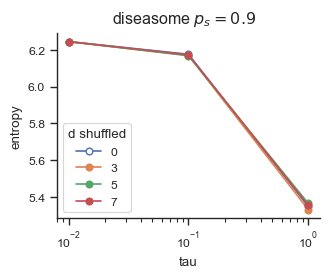

In [9]:
fig, ax = plt.subplots(figsize=(3.4, 2.4))

for i, series in enumerate(ents_df.values):
    mfc = "w" if i == 0 else None
    ax.plot(ents_df.columns, series, "o-", label=ents_df.index[i], mfc=mfc)

ax.set_ylabel("entropy")
ax.set_xlabel("tau")
ax.legend(title="d shuffled")
ax.set_xscale("log", base=10)

sb.despine()

fig.suptitle(f"{name} $p_s={p_shuffle}$")

fig_name = f"info_{name}_p_s_{p_shuffle}_entropy"  # lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"
# plt.savefig(f"{fig_name}.png", dpi=250, bbox_inches="tight")